In [1]:
#import libraries needed
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm, skew, probplot
from scipy.special import boxcox1p
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
import lightgbm as lgb

# Data Importing and Preprocessing

In [2]:
# Read in file
df = pd.read_csv('/Users/tpad/School/Spring 2022 (Senior II)/COMP 494/Final Project/Dataset 2 (House Sales)/house_sales.csv')

In [3]:
# Check to make sure it loaded properly
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3.0,1.00,1180.0,5650.0,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3.0,2.25,2570.0,7242.0,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2.0,1.00,770.0,10000.0,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4.0,3.00,1960.0,5000.0,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3.0,2.00,1680.0,8080.0,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [4]:
# Look at dimensions of the dataset
df.shape

(21613, 21)

In [5]:
df.dtypes 
# date will need to be cleaned and changed to date type and zipcode will need to be transformed to categorical

id                 int64
date              object
price            float64
bedrooms         float64
bathrooms        float64
sqft_living      float64
sqft_lot         float64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

In [6]:
# Change date variable to usable datetime format
df['date'] = pd.to_datetime(df['date'])

# Change zipcode variable to categorical type
df['zipcode'] = df['zipcode'].astype('object')
df.dtypes

id                        int64
date             datetime64[ns]
price                   float64
bedrooms                float64
bathrooms               float64
sqft_living             float64
sqft_lot                float64
floors                  float64
waterfront                int64
view                      int64
condition                 int64
grade                     int64
sqft_above                int64
sqft_basement             int64
yr_built                  int64
yr_renovated              int64
zipcode                  object
lat                     float64
long                    float64
sqft_living15             int64
sqft_lot15                int64
dtype: object

In [7]:
# count the number of categorical variables
categorical = 0
for dtype in df.dtypes:
    if dtype == 'object':
        categorical = categorical + 1

In [8]:
print('# of categorical variables:',categorical)
print('# of contineous variables:',df.shape[1] - categorical - 1) # subtract an extra column as 1 column is an ID column

# of categorical variables: 1
# of contineous variables: 19


In [9]:
# Verify changes worked properly
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3.0,1.00,1180.0,5650.0,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3.0,2.25,2570.0,7242.0,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2.0,1.00,770.0,10000.0,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4.0,3.00,1960.0,5000.0,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3.0,2.00,1680.0,8080.0,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [10]:
# Identify missing values
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
bedrooms,1134,0.052468
sqft_living,1110,0.051358
bathrooms,1068,0.049415
sqft_lot,1044,0.048304
id,0,0.000000
sqft_basement,0,0.000000
sqft_living15,0,0.000000
long,0,0.000000
lat,0,0.000000
zipcode,0,0.000000


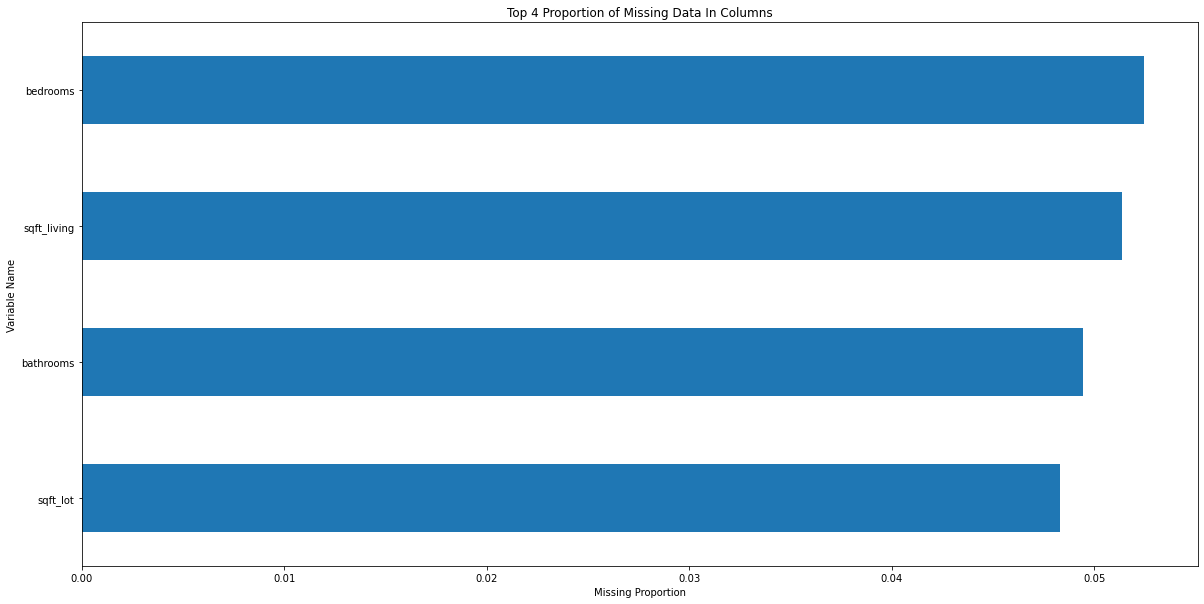

In [11]:
missing_data['Percent'].head(4).plot(kind='barh', figsize = (20,10)).invert_yaxis() #top 10 missing columns
plt.xlabel("Missing Proportion")
plt.ylabel("Variable Name")
plt.title("Top 4 Proportion of Missing Data In Columns")
plt.show()

In [12]:
# Imputing missing values using the median based on zipcode
df["sqft_living"] = df.groupby("zipcode")["sqft_living"].transform(lambda x: x.fillna(x.median()))
df["sqft_lot"] = df.groupby("zipcode")["sqft_lot"].transform(lambda x: x.fillna(x.median()))

# Imputing missing values using the mode based on zipcode
df["bedrooms"] = df.groupby("zipcode")["bedrooms"].transform(lambda x: x.fillna(round(x.median(),0)))
df["bathrooms"] = df.groupby("zipcode")["bathrooms"].transform(lambda x: x.fillna((round((x.median()*2),0)/2)))

In [13]:
# Check to make sure all Null values have been handled
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
id,0,0.0
grade,0,0.0
sqft_living15,0,0.0
long,0,0.0
lat,0,0.0
zipcode,0,0.0
yr_renovated,0,0.0
yr_built,0,0.0
sqft_basement,0,0.0
sqft_above,0,0.0


Handle Outliers

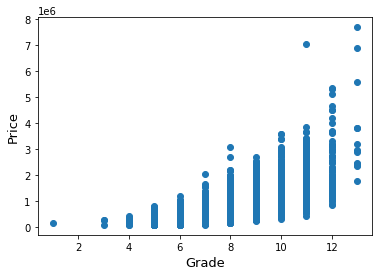

In [14]:
fig, ax = plt.subplots()
ax.scatter(x = df['grade'], y = df['price'])
plt.ylabel('Price', fontsize=13)
plt.xlabel('Grade', fontsize=13)
plt.show()

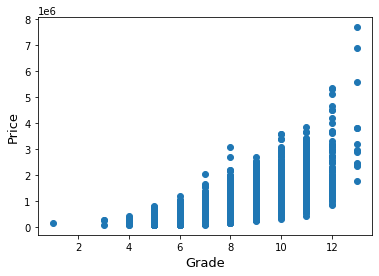

In [15]:
# Deleting outliers
df = df.drop(df[(df['grade']<12) & (df['price']>6000000)].index)

# Check graph again
fig, ax = plt.subplots()
ax.scatter(x = df['grade'], y = df['price'])
plt.ylabel('Price', fontsize=13)
plt.xlabel('Grade', fontsize=13)
plt.show()

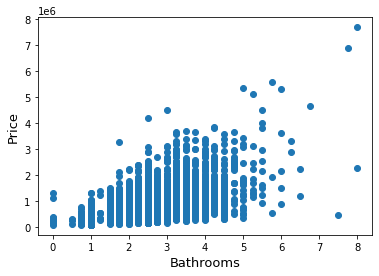

In [16]:
fig, ax = plt.subplots()
ax.scatter(x = df['bathrooms'], y = df['price'])
plt.ylabel('Price', fontsize=13)
plt.xlabel('Bathrooms', fontsize=13)
plt.show()

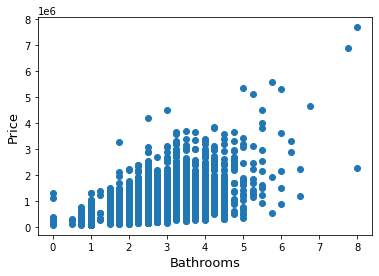

In [17]:
# Deleting outliers
df = df.drop(df[(df['bathrooms']>7) & (df['price']<1000000)].index)

# Check graph again
fig, ax = plt.subplots()
ax.scatter(x = df['bathrooms'], y = df['price'])
plt.ylabel('Price', fontsize=13)
plt.xlabel('Bathrooms', fontsize=13)
plt.show()

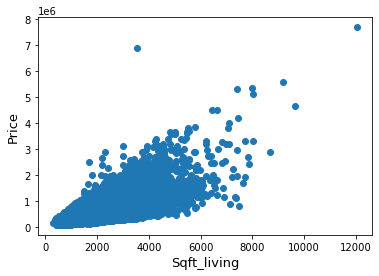

In [18]:
fig, ax = plt.subplots()
ax.scatter(x = df['sqft_living'], y = df['price'])
plt.ylabel('Price', fontsize=13)
plt.xlabel('Sqft_living', fontsize=13)
plt.show()

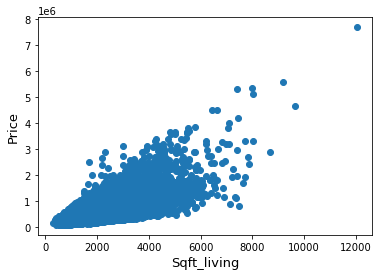

In [19]:
# Deleting outliers
df = df.drop(df[(df['sqft_living']<4000) & (df['price']>6000000)].index)

# Check graph again
fig, ax = plt.subplots()
ax.scatter(x = df['sqft_living'], y = df['price'])
plt.ylabel('Price', fontsize=13)
plt.xlabel('Sqft_living', fontsize=13)
plt.show()

Normalize Target Variable


 mu = 539496.88 and sigma = 361887.52



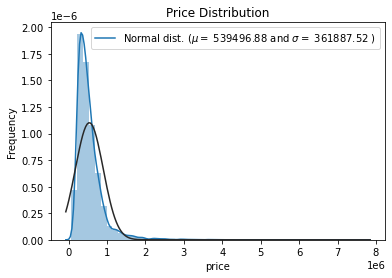

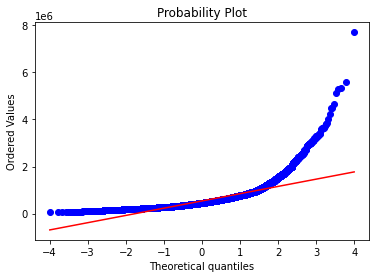

In [20]:
sns.distplot(df['price'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df['price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# Plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')
plt.ylabel('Frequency')
plt.title('Price Distribution')

# Also get the QQ-plot
fig = plt.figure()
res = probplot(df['price'], plot=plt)
plt.show()


 mu = 13.05 and sigma = 0.53



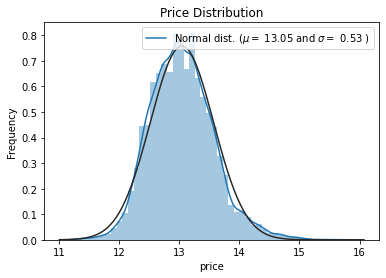

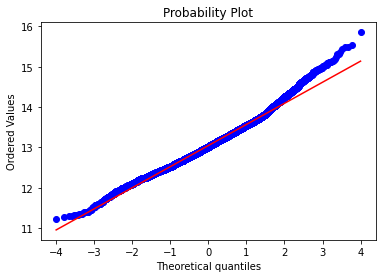

In [21]:
# Use the numpy fuction log1p which  applies log(1+x) to all elements of the column
df["price"] = np.log1p(df["price"])

# Check the new distribution 
sns.distplot(df['price'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df['price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# Plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Price Distribution')

# Also get the QQ-plot
fig = plt.figure()
res = probplot(df['price'], plot=plt)
plt.show()

In [72]:
# Look at dimensions of the dataset
df.shape

(21610, 90)

# Data Analysis and Visualization

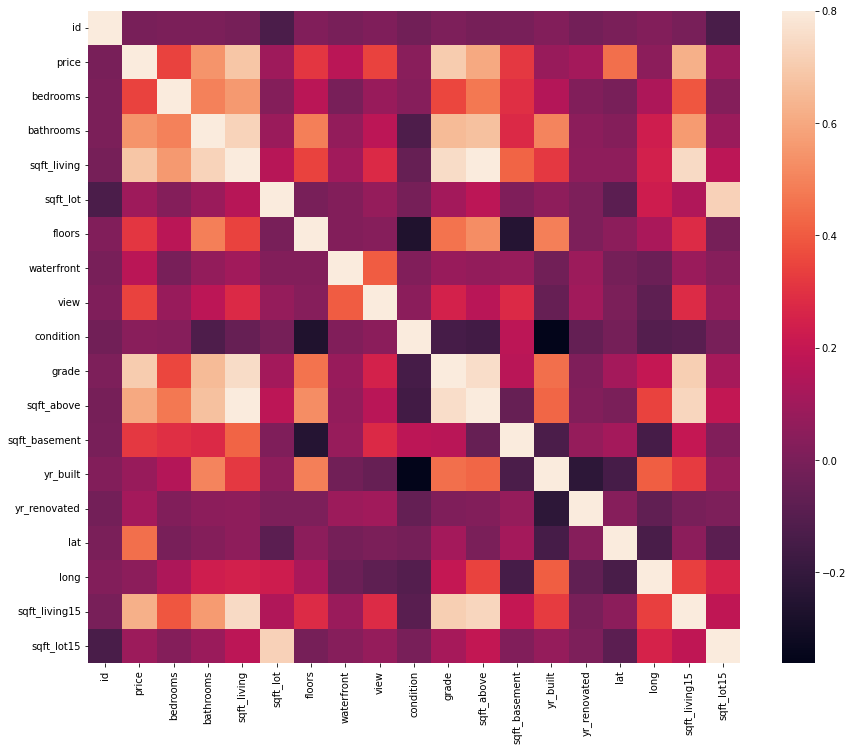

In [23]:
# Correlation map to see how features are correlated with SalePrice
corrmat = df.corr()
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(corrmat, vmax=.8, square=True);

Determined that bathrooms, sqft_living, and grade are the most correlated with price

Removing redundant variables such as lat and long since we already have zipcode
Also removing sqft_living15 and sqft_lot15 because they are redundant
Also removing year renovated because most are coded as 0

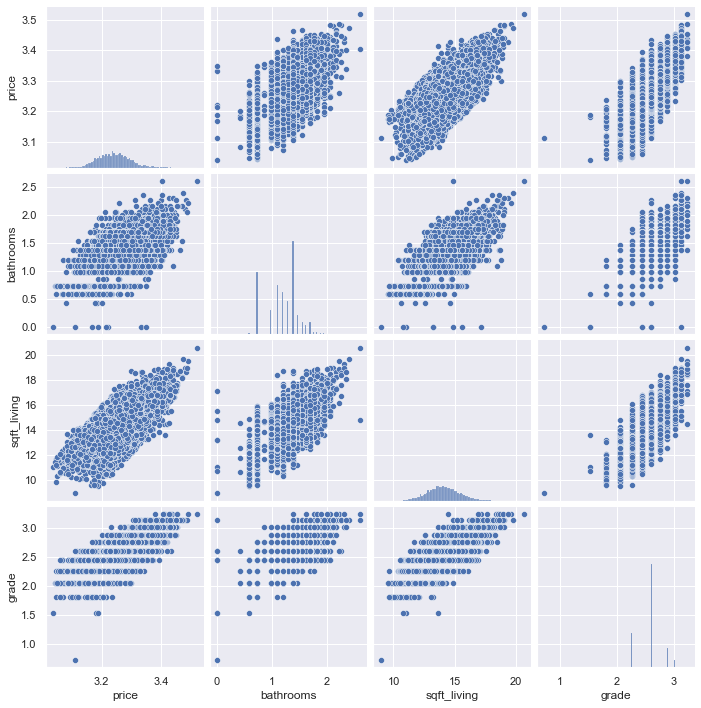

In [73]:
#scatterplot
sns.set()
cols = ['price','bathrooms', 'sqft_living', 'grade'] 
# Good correlations seen with grade, bathrooms, and sqft_living
sns.pairplot(df[cols], size = 2.5)
plt.show();

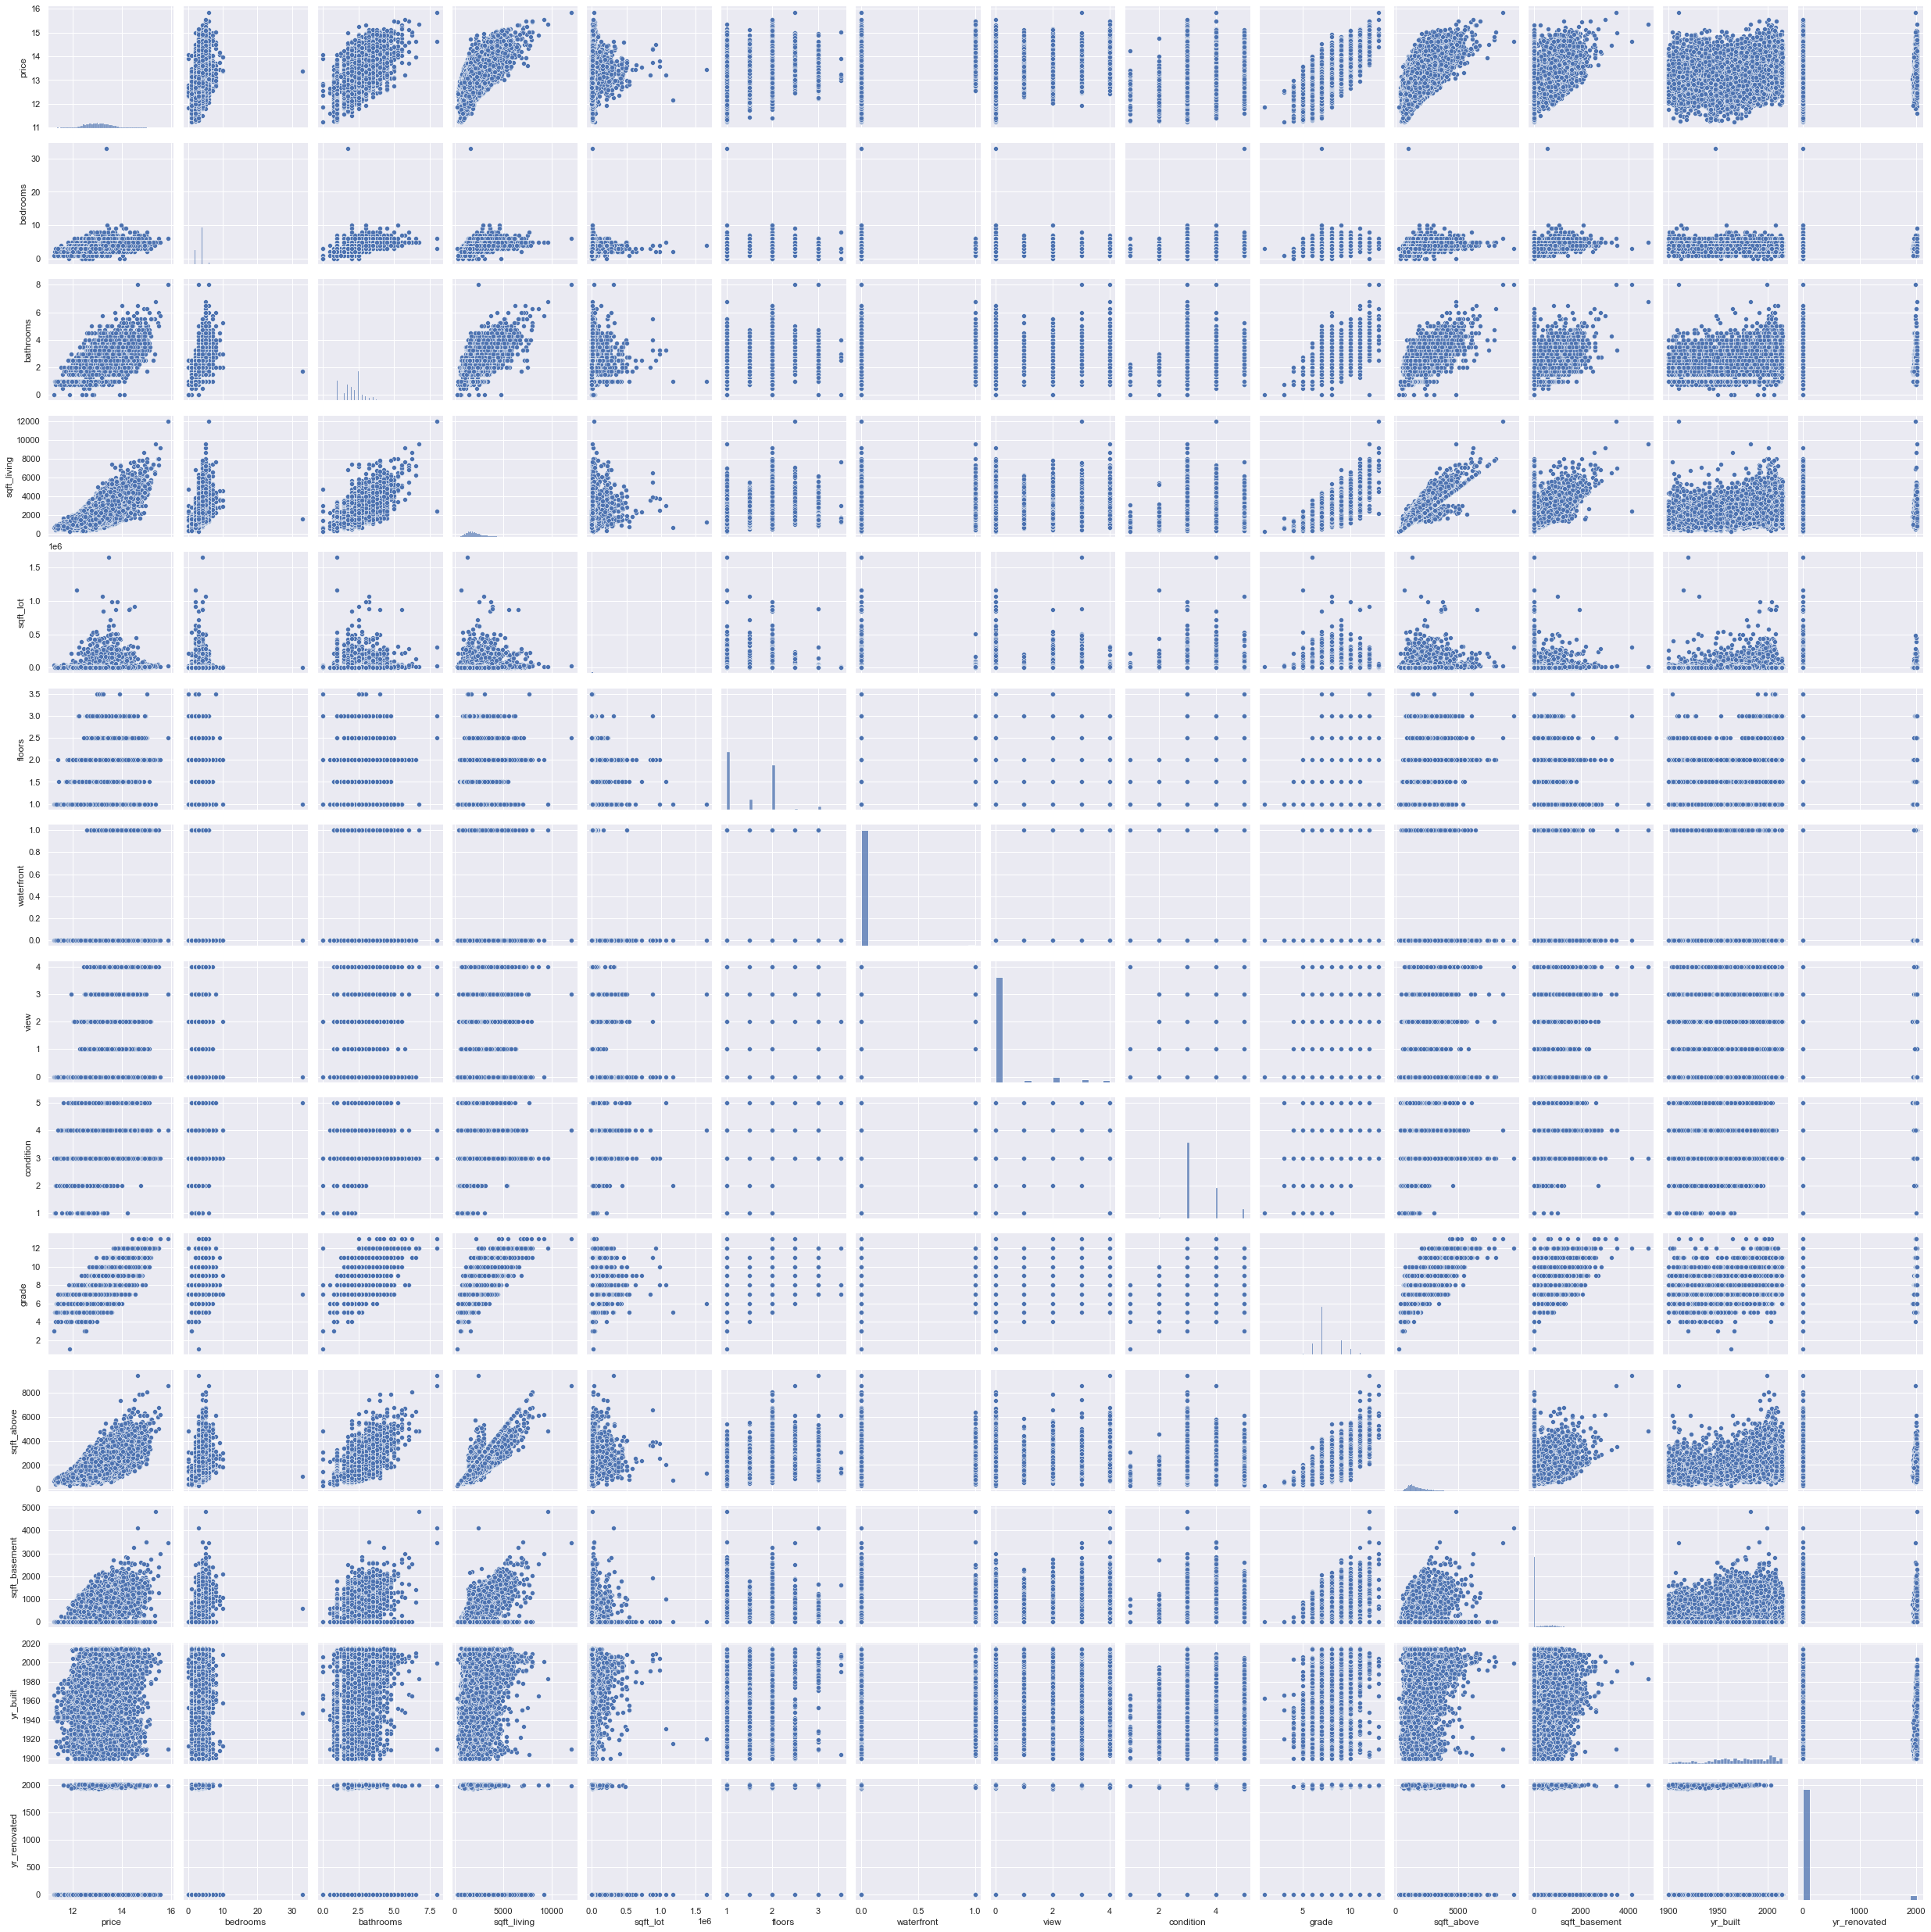

In [26]:
#scatterplot
sns.set()
cols = ['price','bedrooms','bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated'] 
# Good correlations seen with grade, bathrooms, and sqft_living
sns.pairplot(df[cols], size = 2.5)
plt.show();

In [27]:
features = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'condition', 'grade', 'sqft_above', 'sqft_basement']

# Check the skew of all numeric features
skewed_feats = df[features].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
sqft_lot,13.186167
bedrooms,2.060659
sqft_basement,1.576350
sqft_above,1.415432
sqft_living,1.398984
condition,1.032519
grade,0.768090
floors,0.616480
bathrooms,0.474868
price,0.418367


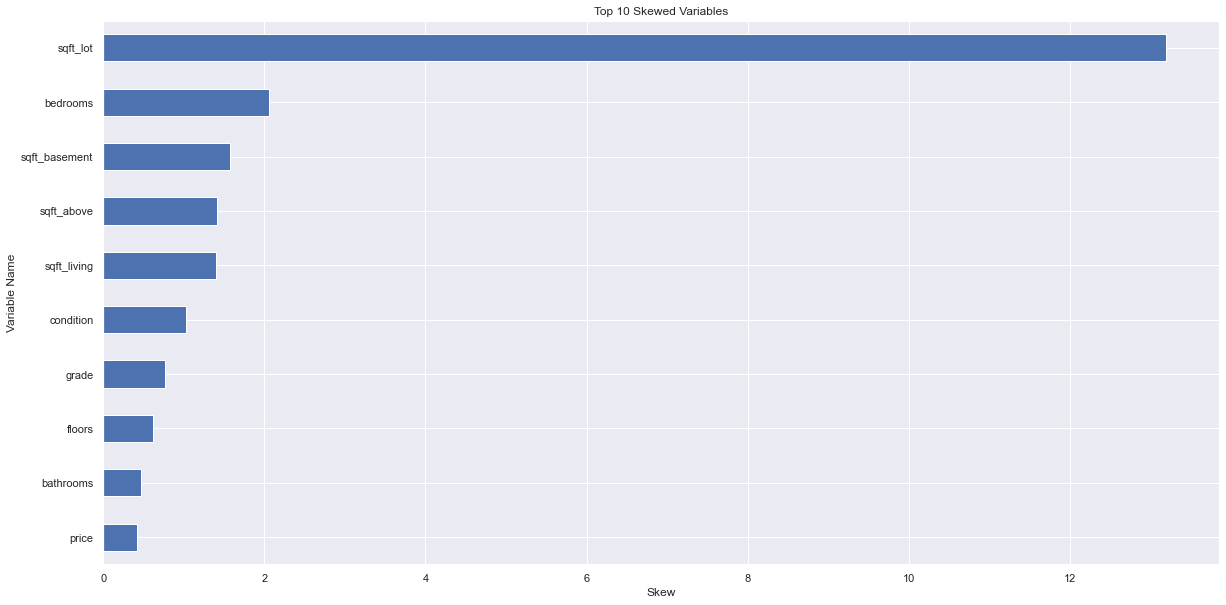

In [28]:
skewness['Skew'].head(10).plot(kind='barh', figsize = (20,10)).invert_yaxis() #top 10 missing columns
plt.xlabel("Skew")
plt.ylabel("Variable Name")
plt.title("Top 10 Skewed Variables")
plt.show()

In [29]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform (normalize)".format(skewness.shape[0]))

skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    df[feat] = boxcox1p(df[feat], lam)

There are 10 skewed numerical features to Box Cox transform (normalize)


In [32]:
# Create dummies 
df = pd.get_dummies(df)
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,zipcode_98001,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,7129300520,2014-10-13,3.162923,1.540963,0.730463,12.597323,17.696152,0.730463,0,0,1.540963,2.440268,12.597323,0.000000,1955,0,47.5112,-122.257,1340,5650,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,6414100192,2014-12-09,3.258364,1.540963,1.289269,14.981646,18.620287,1.194318,0,0,1.540963,2.440268,14.439420,9.715842,1951,1991,47.7210,-122.319,1690,7639,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,5631500400,2015-02-25,3.139584,1.194318,0.730463,11.403697,19.874209,0.730463,0,0,1.540963,2.259674,11.403697,0.000000,1933,0,47.7379,-122.233,2720,8062,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2487200875,2014-12-09,3.270458,1.820334,1.540963,14.119786,17.253669,0.730463,0,0,2.055642,2.440268,12.263269,11.861673,1965,0,47.5208,-122.393,1360,5000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,1954400510,2015-02-18,3.252750,1.540963,1.194318,13.644922,19.038978,0.730463,0,0,1.540963,2.602594,13.644922,0.000000,1987,0,47.6168,-122.045,1800,7503,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Data Analytics

In [34]:
# Create training dataframe
train_df = df[['bathrooms', 'sqft_living', 'grade']]
train_df.head()

,bathrooms,sqft_living,grade
0,0.730463,12.597323,2.440268
1,1.289269,14.981646,2.440268
2,0.730463,11.403697,2.259674
3,1.540963,14.119786,2.440268
4,1.194318,13.644922,2.602594


In [35]:
#Validation function
n_folds = 5

def rmse_cv(model,n_folds):
    kf=KFold(n_splits=n_folds)
    rmse = np.sqrt(-cross_val_score(model, train_df, df.price, scoring="neg_mean_squared_error", cv = kf))
    return rmse

In [36]:
lr_w_int = LinearRegression()
lr_no_int = LinearRegression(fit_intercept=False)

In [37]:
neigh = KNeighborsRegressor(n_neighbors=10)

In [38]:
rf = RandomForestRegressor(n_estimators=100)

In [39]:
dt = DecisionTreeRegressor(max_depth = 10)

In [40]:
model_xgb = xgb.XGBRegressor(max_depth=5, n_estimators=1000, learning_rate=0.01)

In [41]:
model_lgb = lgb.LGBMRegressor(learning_rate=0.01, max_depth=5, n_estimators=1000)

Running the Algorithms

In [42]:
score_linear = rmse_cv(lr_w_int,n_folds)
print("Linear Regression (w/ Intercept) score: {:.4f} ({:.4f})\n".format(score_linear.mean(), score_linear.std()))

Linear Regression (w/ Intercept) score: 0.0377 (0.0013)



In [43]:
score_linear_no_int = rmse_cv(lr_no_int,n_folds)
print("Linear Regression (No Intercept) score: {:.4f} ({:.4f})\n".format(score_linear_no_int.mean(), score_linear_no_int.std()))

Linear Regression (No Intercept) score: 0.1726 (0.0022)



In [44]:
score_neigh = rmse_cv(neigh,n_folds)
print("Nearest Neighbor (13) score: {:.4f} ({:.4f})\n".format(score_neigh.mean(), score_neigh.std()))

Nearest Neighbor (13) score: 0.0385 (0.0014)



In [45]:
score_dt = rmse_cv(dt,n_folds)
print("Decision Tree Regression score: {:.4f} ({:.4f})\n".format(score_dt.mean(), score_dt.std()))

Decision Tree Regression score: 0.0385 (0.0010)



In [46]:
score_rf = rmse_cv(rf,n_folds)
print("Random Forest Regression score: {:.4f} ({:.4f})\n".format(score_rf.mean(), score_rf.std()))

Random Forest Regression score: 0.0400 (0.0010)



In [47]:
score_xg = rmse_cv(model_xgb,n_folds)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score_xg.mean(), score_xg.std()))

Xgboost score: 0.0368 (0.0014)



In [48]:
score_lgbm = rmse_cv(model_lgb,n_folds)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score_lgbm.mean(), score_lgbm.std()))

LGBM score: 0.0368 (0.0014)



In [49]:
#plot RMSE and STD for each Algorithm
data = {'Linear (No Intercept)':[score_linear_no_int.mean(),score_linear_no_int.std()], 'XGBoost':[score_xg.mean(),score_xg.std()], 'Random Forest': [score_rf.mean(),score_rf.std()]
        , 'LightGBM': [score_lgbm.mean(),score_lgbm.std()], 'Decision Tree': [score_dt.mean(),score_dt.std()],'Nearest Neighbor': [score_neigh.mean(),score_neigh.std()]}
data_df = pd.DataFrame(data=data).T.reset_index().sort_values(by = [0],ascending = True)
data_df.columns = ['Algorithm','RMSE','STD']

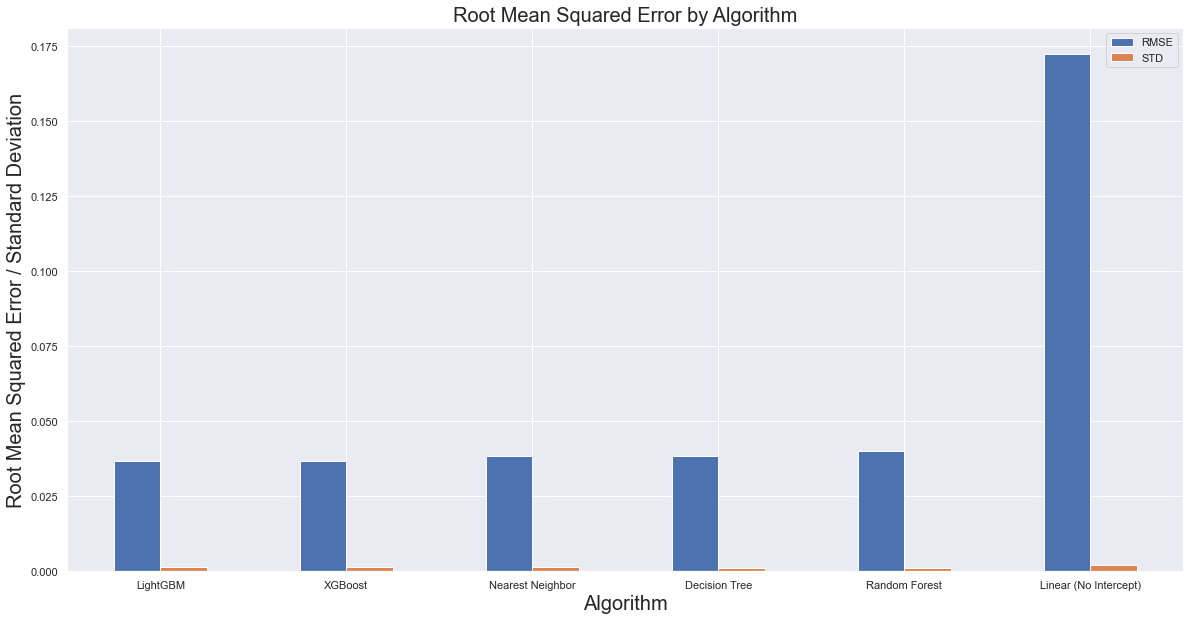

In [50]:
# creating the bar plot
data_df.plot(kind='bar',x = 'Algorithm', y = ['RMSE', 'STD'], figsize = (20,10), rot=0)
plt.xlabel("Algorithm",fontsize=20)
plt.ylabel("Root Mean Squared Error / Standard Deviation",fontsize=20)
plt.title("Root Mean Squared Error by Algorithm",fontsize=20)
plt.show()

Variables Importance Plot

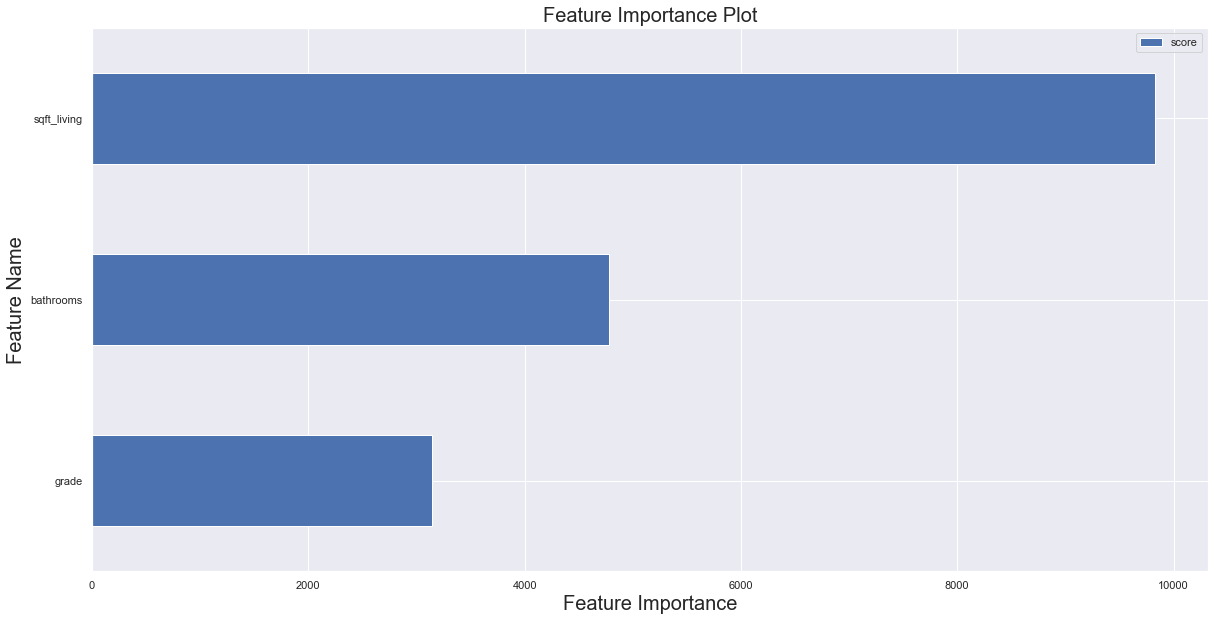

In [51]:
model = model_xgb.fit(train_df, df.price) #fit model on entire dataset to get variable importance since we fit it on each fold
feature_important = model.get_booster().get_score(importance_type='weight')

keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data[:20].plot(kind='barh', figsize = (20,10)).invert_yaxis(); ## plot top 20 features
plt.xlabel("Feature Importance",fontsize=20)
plt.ylabel("Feature Name",fontsize=20)
plt.title("Feature Importance Plot",fontsize=20)
plt.show()

Re-running the Algorithms

In [61]:
# Re-create training dataframe
#train_df = df[['bedrooms','bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated']]
train_df = df[df.columns.difference(['id', 'price','sqft_living15','sqft_lot15', 'date','lat','long','yr_renovated'])]

train_df.head()

,bathrooms,bedrooms,condition,floors,grade,sqft_above,sqft_basement,sqft_living,sqft_lot,view,waterfront,yr_built,zipcode_98001,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,0.730463,1.540963,1.540963,0.730463,2.440268,12.597323,0.000000,12.597323,17.696152,0,0,1955,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,1.289269,1.540963,1.540963,1.194318,2.440268,14.439420,9.715842,14.981646,18.620287,0,0,1951,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.730463,1.194318,1.540963,0.730463,2.259674,11.403697,0.000000,11.403697,19.874209,0,0,1933,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.540963,1.820334,2.055642,0.730463,2.440268,12.263269,11.861673,14.119786,17.253669,0,0,1965,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,1.194318,1.540963,1.540963,0.730463,2.602594,13.644922,0.000000,13.644922,19.038978,0,0,1987,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [62]:
score_linear = rmse_cv(lr_w_int,n_folds)
print("Linear Regression (w/ Intercept) score: {:.4f} ({:.4f})\n".format(score_linear.mean(), score_linear.std()))

Linear Regression (w/ Intercept) score: 0.0196 (0.0003)



In [63]:
score_linear_no_int = rmse_cv(lr_no_int,n_folds)
print("Linear Regression (No Intercept) score: {:.4f} ({:.4f})\n".format(score_linear_no_int.mean(), score_linear_no_int.std()))

Linear Regression (No Intercept) score: 0.0196 (0.0003)



In [64]:
score_neigh = rmse_cv(neigh,n_folds)
print("Nearest Neighbor (13) score: {:.4f} ({:.4f})\n".format(score_neigh.mean(), score_neigh.std()))

Nearest Neighbor (13) score: 0.0339 (0.0004)



In [65]:
score_dt = rmse_cv(dt,n_folds)
print("Decision Tree Regression score: {:.4f} ({:.4f})\n".format(score_dt.mean(), score_dt.std()))

Decision Tree Regression score: 0.0315 (0.0009)



In [66]:
score_rf = rmse_cv(rf,n_folds)
print("Random Forest Regression score: {:.4f} ({:.4f})\n".format(score_rf.mean(), score_rf.std()))

Random Forest Regression score: 0.0227 (0.0007)



In [67]:
score_xg = rmse_cv(model_xgb,n_folds)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score_xg.mean(), score_xg.std()))

Xgboost score: 0.0231 (0.0006)



In [68]:
score_lgbm = rmse_cv(model_lgb,n_folds)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score_lgbm.mean(), score_lgbm.std()))

LGBM score: 0.0228 (0.0006)



In [69]:
#plot RMSE and STD for each Algorithm
data = {'Linear (No Intercept)':[score_linear_no_int.mean(),score_linear_no_int.std()], 'XGBoost':[score_xg.mean(),score_xg.std()], 'Random Forest': [score_rf.mean(),score_rf.std()]
        , 'LightGBM': [score_lgbm.mean(),score_lgbm.std()], 'Decision Tree': [score_dt.mean(),score_dt.std()],'Nearest Neighbor': [score_neigh.mean(),score_neigh.std()]}
data_df = pd.DataFrame(data=data).T.reset_index().sort_values(by = [0],ascending = True)
data_df.columns = ['Algorithm','RMSE','STD']

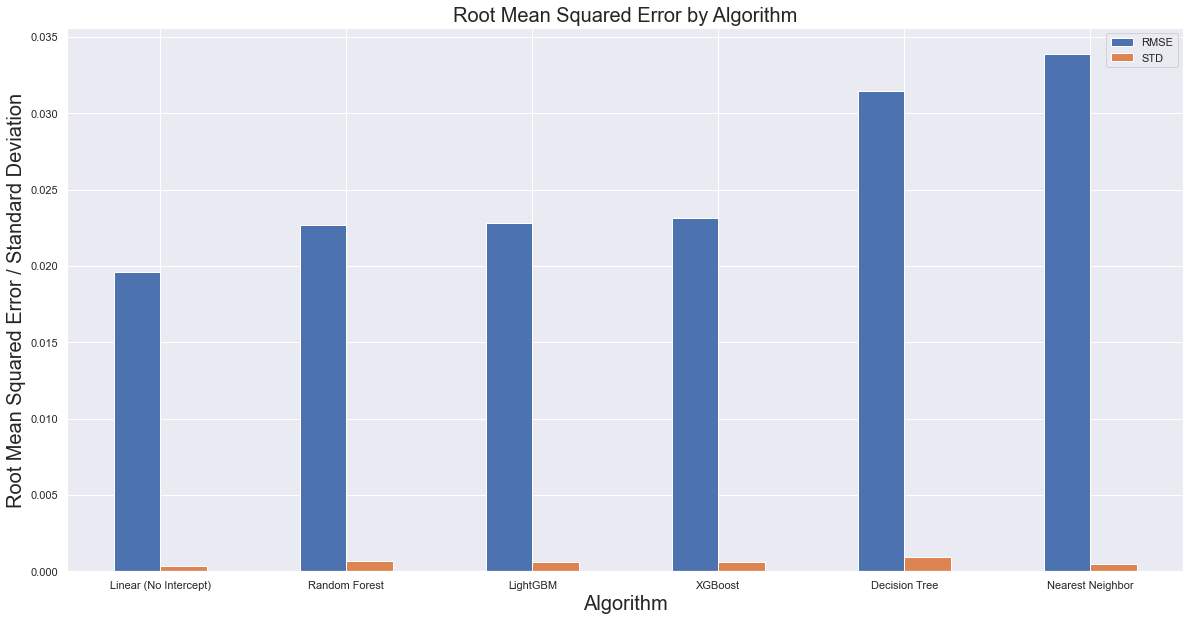

In [70]:
# creating the bar plot
data_df.plot(kind='bar',x = 'Algorithm', y = ['RMSE', 'STD'], figsize = (20,10), rot=0)
plt.xlabel("Algorithm",fontsize=20)
plt.ylabel("Root Mean Squared Error / Standard Deviation",fontsize=20)
plt.title("Root Mean Squared Error by Algorithm",fontsize=20)
plt.show()

Variables Importance Plot

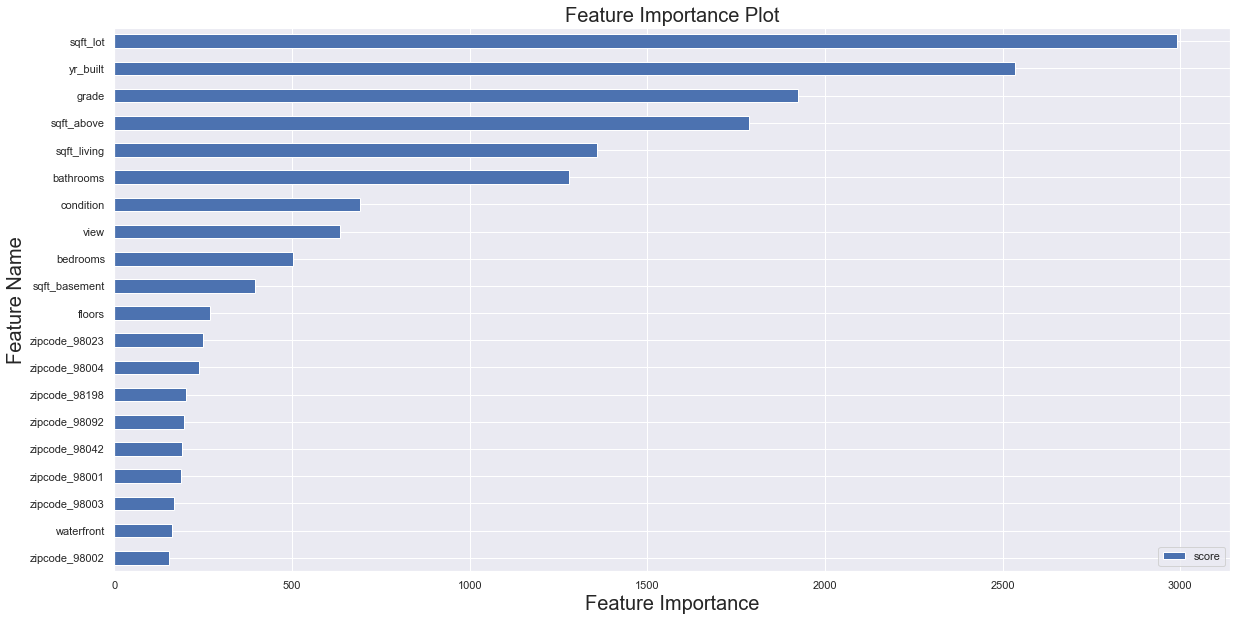

In [71]:
model = model_xgb.fit(train_df, df.price) #fit model on entire dataset to get variable importance since we fit it on each fold
feature_important = model.get_booster().get_score(importance_type='weight')

keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data[:20].plot(kind='barh', figsize = (20,10)).invert_yaxis(); ## plot top 20 features
plt.xlabel("Feature Importance",fontsize=20)
plt.ylabel("Feature Name",fontsize=20)
plt.title("Feature Importance Plot",fontsize=20)
plt.show()